In [36]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="gemma2-9b-it")

In [37]:
from langchain_community.tools import DuckDuckGoSearchRun
searchEngine = DuckDuckGoSearchRun()

In [38]:
def add(a:int, b:int)-> int:
    "add two int value"
    return a + b

In [39]:
def minus(a:int, b:int)-> int:
    "subtract two int value"
    return a - b

In [40]:
def product(a:int, b:int)-> int:
    "multiply two int value"
    return a*b

In [41]:
def divide(a:int, b:int)-> int:
    "divide two int value"
    return a/b

In [42]:
tools = [add,minus,product,divide,searchEngine]
llm_with_tools = llm.bind_tools(tools)

In [43]:
from langgraph.graph import MessagesState
def chatbot(state:MessagesState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages":[response]}

In [44]:
def route(state:MessagesState):
    messages = state["messages"]
    if messages[-1].tool_calls:
        return "tools_call"
    return END

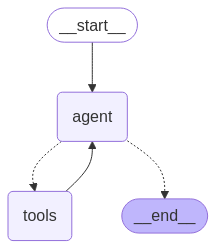

In [45]:
from langgraph.graph import StateGraph, START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

workflow = StateGraph(MessagesState)

workflow.add_node("agent",chatbot)
workflow.add_node("tools",ToolNode(tools))

workflow.add_edge(START,"agent")
workflow.add_conditional_edges(
    "agent",
    # ways 1
    # route,
    # {
    #     "tools_call":"tools",
    #     END:END
    # }

    # ways 2
    tools_condition,
)
workflow.add_edge("tools","agent")

app = workflow.compile()
app


In [46]:
from langchain_core.messages import HumanMessage
message = [HumanMessage(content="What is 2 times of narendra modi's age?")]
result = app.invoke({"messages": message})

In [47]:
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times of narendra modi's age?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_0g3y)
 Call ID: call_0g3y
  Args:
    query: narendra modi age
================================= Tool Message =================================
Name: duckduckgo_search

Narendra Modi is the prime minister of India since 2014 and a leader of the BJP. He was born on September 17, 1950, in Vadnagar, India, and is a member of the RSS. List of all Prime Ministers of India till 2025: Narendra Modi is the current and 14th Prime Minister of India who assumed office on 10 June 2024. Jawaharlal Nehru is the first and the longest ... Learn about the life and achievements of Narendra Modi, the current Prime Minister of India, who was born on September 17, 1950, in Gujarat. Find out his full name, education, political journey, and role in the BJP and RSS. Learn 

## Finance tool

In [71]:
import yfinance as yf

def get_stock_price(ticker: str) -> float:
    """Gets a stock price from Yahoo Finance.
    Args:
        ticker: ticker str
    """
    stock = yf.Ticker(ticker)
    return stock.info['previousClose']


In [72]:
get_stock_price("AAPL")

202.14

In [73]:
tools = [add,minus,product,divide,searchEngine,get_stock_price]
llm_with_tools = llm.bind_tools(tools)

In [75]:
from langchain_core.messages import AnyMessage

class GraphState(TypedDict):
    """State of the graph."""
    query: str
    finance: str
    final_answer: str
    # intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[list[AnyMessage], operator.add]

In [80]:
from langchain_core.messages import HumanMessage,SystemMessage
def reasoner(state):
    query = state["query"]
    messages = state["messages"]
    # System message
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
    message = HumanMessage(content=query)
    messages.append(message)
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages":result}

In [81]:

# Graph
workflow = StateGraph(GraphState)

# Add Nodes
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools)) # for the tools

# Add Edges
workflow.add_edge(START, "reasoner")

workflow.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "reasoner")
react_graph = workflow.compile()

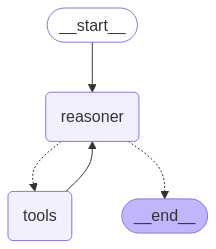

In [78]:
react_graph

In [85]:
response = react_graph.invoke({"query": "What is the stock price of google add 1000?", "messages": []})

In [86]:
for m in response['messages']:
    m.pretty_print()
     

================================ Human Message =================================

What is the stock price of google add 1000?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_y9wm)
 Call ID: call_y9wm
  Args:
    ticker: GOOG
================================= Tool Message =================================
Name: get_stock_price

158.68
================================ Human Message =================================

What is the stock price of google add 1000?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_e2rt)
 Call ID: call_e2rt
  Args:
    ticker: GOOG
================================= Tool Message =================================
Name: get_stock_price

158.68
================================ Human Message =================================

What is the stock price of google add 1000?
================================== Ai Message ==================